In [1]:
import sys; sys.path.append('../')
import argparse
import os
from chemvae_torch import hyperparameters
from chemvae import models
from pathlib import Path
import json
import keras
from keras import layers
from chemvae.tgru_k2_gpu import TerminalGRU
from keras.layers import GRU
import numpy as np
import keras.backend as K
import torch
from torchsummary import summary
from chemvae_torch.models_torch import (
    EncoderModel, 
    DecoderModel, 
    PropertyPredictorModel, 
    CustomBatchNorm1d,
    CustomGRU,
)
from chemvae.models import encoder_model, decoder_model
from chemvae_torch import mol_utils as mu
import yaml
# from chemvae_torch.tgru_torch import CustomGRU
import h5py
import copy
import pandas as pd 
import matplotlib.pyplot as plt
from chemvae_torch.utils_torch import smiles_to_hot, hot_to_smiles

In [2]:
num_layers = 1
hidden_size = 35
input_size = 196
custom_gru = CustomGRU(input_size, hidden_size, num_layers)

In [3]:
# random input with size (1, 120, 196)
input = torch.randn(10, 120, 196)
target = torch.randn(10, 120, 35)

x = custom_gru(input, targets=target)

In [4]:
x[0].size()

torch.Size([10, 120, 35])

Loading Keras models (encoder, decoder and property predictor)

In [5]:
# Load params

params = hyperparameters.load_params(None)
encoder_path = Path.cwd().parent / "checkpoints/zinc_properties/zinc_encoder.h5"
decoder_path = Path.cwd().parent / "checkpoints/zinc_properties/zinc_decoder.h5"
prop_pred_path = Path.cwd().parent / "checkpoints/zinc_properties/zinc_prop_pred.h5"
print("All params:", params)

with open('../checkpoints/zinc_properties/exp.json') as json_file:
    exp_params = json.load(json_file)
params.update(exp_params)
params["encoder_weights_file"] = encoder_path
params["decoder_weights_file"] = decoder_path
params["prop_pred_weights_file"] = prop_pred_path
params["reg_prop_tasks"] = ["qed","SAS","logP"]
params["NCHARS"] = 35
params["prop_hidden_dim"] = 67
params["prop_growth_factor"] = 0.99028340731314179
params["prop_pred_dropout"] = 0.15694573998898703
params["do_prop_pred"] = True
params["dropout_rate_mid"] = 0
params["do_tgru"] = True

params["char_file"] = "../checkpoints/zinc_properties/zinc.json"
chars = yaml.safe_load(open(params["char_file"]))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# Load encoder model
encoder = models.load_encoder(params)
prop_pred = models.load_property_predictor(params)
# decoder = models.load_decoder(params) >>>> Doesn't work. Inconsistent "reset_after = True" (GRU Layer)
decoder = decoder_model(params)

All params: {'reload_model': False, 'prev_epochs': 0, 'batch_size': 100, 'epochs': 1, 'val_split': 0.1, 'loss': 'categorical_crossentropy', 'batchnorm_conv': True, 'conv_activation': 'tanh', 'conv_depth': 4, 'conv_dim_depth': 8, 'conv_dim_width': 8, 'conv_d_growth_factor': 1.15875438383, 'conv_w_growth_factor': 1.1758149644, 'gru_depth': 4, 'rnn_activation': 'tanh', 'recurrent_dim': 50, 'do_tgru': True, 'terminal_GRU_implementation': 0, 'tgru_dropout': 0.0, 'temperature': 1.0, 'hg_growth_factor': 1.4928245388, 'hidden_dim': 100, 'middle_layer': 1, 'dropout_rate_mid': 0.0, 'batchnorm_mid': True, 'activation': 'tanh', 'lr': 0.000312087049936, 'momentum': 0.936948773087, 'optim': 'adam', 'vae_annealer_start': 22, 'batchnorm_vae': False, 'vae_activation': 'tanh', 'xent_loss_weight': 1.0, 'kl_loss_weight': 1.0, 'anneal_sigmod_slope': 1.0, 'freeze_logvar_layer': False, 'freeze_offset': 1, 'do_prop_pred': False, 'prop_pred_depth': 3, 'prop_hidden_dim': 36, 'prop_growth_factor': 0.8, 'prop_pre

No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


`implementation=0` has been deprecated, and now defaults to `implementation=2`.Please update your layer call.


Utils

In [6]:
# def hot_to_smiles(hot_x, indices_chars):
    
#     assert type(hot_x) == np.ndarray
#     assert len(hot_x.shape) == 3
    
#     smiles = []
#     for i in range(hot_x.shape[0]):  # number of samples
#         temp_str = ""
#         for j in range(hot_x.shape[1]):  # length of smiles
#             index = np.argmax(hot_x[i, j, :])
#             temp_str += indices_chars[index]
#         smiles.append(temp_str)
#     return smiles

# def smiles_to_hot(smiles, params, canonize_smiles=True, check_smiles=False):
#     if isinstance(smiles, str):
#         smiles = [smiles]

#     if canonize_smiles:
#         smiles = [mu.canon_smiles(s) for s in smiles]

#     if check_smiles:
#         smiles = mu.smiles_to_hot_filter(smiles, char_indices)

#     z = mu.smiles_to_hot(smiles, params["MAX_LEN"], params["PADDING"], char_indices, params["NCHARS"])
#     return z

Loading Decoder Weights from .h5

In [7]:
# Loading decoder weights from .h5 file (couldn't be retrieve through Keras)

with h5py.File(Path.cwd().parent / 'checkpoints/zinc_properties/zinc_decoder.h5', 'r') as f:
    groups = f["model_weights"].keys()
    # remove following keys from groups: "decoder_input", "decoder_true_seq_input", "dropout_2" and "repeat_vector_1".
    groups = [group for group in groups if group not in ["decoder_input", "decoder_true_seq_input", "dropout_2", "repeat_vector_1"]]
    # create a dictionary to store the weights
    decoder_weights = {}
    for group in groups:
        layers = f["model_weights"][group][group]
        decoder_weights[group] = {}
        for layer in layers:
            decoder_weights[group][layer] = layers[layer][:]

In [8]:
decoder_weights.keys()

dict_keys(['decoder_dense0', 'decoder_dense0_norm', 'decoder_gru0', 'decoder_gru1', 'decoder_gru2', 'decoder_tgru'])

In [9]:
decoder_weights['decoder_tgru'].keys()

dict_keys(['bias:0', 'kernel:0', 'recurrent_kernel:0'])

In [10]:
decoder_weights['decoder_tgru']['bias:0']

array([ 0.07630397,  0.0938621 ,  0.14537051, -0.11812074, -0.05098865,
        0.00967122, -0.22757071,  0.0446885 , -0.30404797, -0.06838284,
        0.14985387,  0.07082494, -0.25643885, -0.25956175, -0.01466649,
        0.21167108, -0.02644513, -0.01929409,  0.04419997, -0.19289875,
       -0.3701925 ,  0.12212047, -0.26673523, -0.18654464,  0.06947502,
        0.17488804, -0.25584635, -0.16099837, -0.06823719,  0.0774922 ,
       -0.07306144, -0.13687925,  0.03245378,  0.10812427,  0.03547714,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [11]:
decoder_weights['decoder_tgru']['kernel:0'].shape

(488, 105)

In [12]:
decoder_weights['decoder_tgru']['recurrent_kernel:0'][:, :35]

array([[-4.6791311e-02, -3.9624366e-01, -8.3204046e-02, ...,
        -1.8091777e-01,  2.1750703e-01, -6.7279409e-03],
       [ 3.4805767e-02, -6.8788546e-01, -2.7883729e-01, ...,
        -2.4473152e-01,  2.6531985e-01, -4.1594687e-01],
       [ 1.1003852e-01,  3.7750316e-01, -1.3649363e+01, ...,
        -2.1006980e+00, -1.4606676e-01,  6.7773539e-01],
       ...,
       [ 1.4508605e-01,  4.6348670e-01, -2.1986201e-01, ...,
        -1.1308312e+01,  3.0484135e+00,  3.4662657e+00],
       [ 4.5340337e-02,  2.0811528e-01, -1.1783388e+00, ...,
        -4.9314761e+00, -5.5674028e+00, -3.4948710e-01],
       [-1.4486559e-01, -6.4043421e-01, -4.0036826e+00, ...,
        -4.2935257e+00, -1.4234838e+00, -1.1172870e+01]], dtype=float32)

Loading Torch encoder

In [13]:
# Initiliazing Torch version of the model
encoder_torch = EncoderModel(params)
summary(encoder_torch, input_size=(120, 35))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 9, 112]           2,844
 CustomBatchNorm1d-2               [-1, 9, 112]              18
            Conv1d-3               [-1, 9, 104]             738
 CustomBatchNorm1d-4               [-1, 9, 104]              18
            Conv1d-5               [-1, 10, 94]           1,000
 CustomBatchNorm1d-6               [-1, 10, 94]              20
           Flatten-7                  [-1, 940]               0
            Linear-8                  [-1, 196]         184,436
 CustomBatchNorm1d-9                  [-1, 196]             392
           Linear-10                  [-1, 196]          38,612
Total params: 228,078
Trainable params: 228,078
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.06
Params size (MB): 0.87
Estimated T

In [14]:
names = [weight.name for layer in encoder.layers for weight in layer.weights]
weights = encoder.get_weights()

for name, weight in zip(names, weights):
    print(name, weight.shape)

encoder_conv0/kernel:0 (9, 35, 9)
encoder_conv0/bias:0 (9,)
encoder_norm0/gamma:0 (9,)
encoder_norm0/beta:0 (9,)
encoder_norm0/moving_mean:0 (9,)
encoder_norm0/moving_variance:0 (9,)
encoder_conv1/kernel:0 (9, 9, 9)
encoder_conv1/bias:0 (9,)
encoder_norm1/gamma:0 (9,)
encoder_norm1/beta:0 (9,)
encoder_norm1/moving_mean:0 (9,)
encoder_norm1/moving_variance:0 (9,)
encoder_conv2/kernel:0 (11, 9, 10)
encoder_conv2/bias:0 (10,)
encoder_norm2/gamma:0 (10,)
encoder_norm2/beta:0 (10,)
encoder_norm2/moving_mean:0 (10,)
encoder_norm2/moving_variance:0 (10,)
encoder_dense0/kernel:0 (940, 196)
encoder_dense0/bias:0 (196,)
encoder_dense0_norm/gamma:0 (196,)
encoder_dense0_norm/beta:0 (196,)
encoder_dense0_norm/moving_mean:0 (196,)
encoder_dense0_norm/moving_variance:0 (196,)
z_mean_sample/kernel:0 (196, 196)
z_mean_sample/bias:0 (196,)


Encoder: from Keras to Pytorch

In [15]:
# gamma (Keras) <-> weight (PyTorch)
# beta (Keras) <-> bias (PyTorch)
# moving_mean (Keras) <-> running_mean (PyTorch)
# moving_variance (Keras) <-> running_var (PyTorch)

# Conv1D: .tranpose(2, 1, 0) because weights are stored in (kernel_size, input_channels, filters) format in Keras
# versus (filters, input_channels, kernel_size) format in Pytorch

# Conv 0
encoder_torch.conv_layers[0].weight.data = torch.from_numpy(weights[0].transpose(2, 1, 0))  # T
encoder_torch.conv_layers[0].bias.data = torch.from_numpy(weights[1])
# BatchNorm 0
encoder_torch.conv_norm_layers[0].weight.data = torch.from_numpy(weights[2]).view(1, -1)
encoder_torch.conv_norm_layers[0].bias.data = torch.from_numpy(weights[3]).view(1, -1)
encoder_torch.conv_norm_layers[0].running_mean.data = torch.from_numpy(weights[4]).view(1, -1)
encoder_torch.conv_norm_layers[0].running_var.data = torch.from_numpy(weights[5]).view(1, -1)
# Conv 1
encoder_torch.conv_layers[1].weight.data = torch.from_numpy(weights[6].transpose(2, 1, 0))  # T
encoder_torch.conv_layers[1].bias.data = torch.from_numpy(weights[7])
# BatchNorm 1
encoder_torch.conv_norm_layers[1].weight.data = torch.from_numpy(weights[8]).view(1, -1)
encoder_torch.conv_norm_layers[1].bias.data = torch.from_numpy(weights[9]).view(1, -1)
encoder_torch.conv_norm_layers[1].running_mean.data = torch.from_numpy(weights[10]).view(1, -1)
encoder_torch.conv_norm_layers[1].running_var.data = torch.from_numpy(weights[11]).view(1, -1)
# Conv 2
encoder_torch.conv_layers[2].weight.data = torch.from_numpy(weights[12].transpose(2, 1, 0))  # T
encoder_torch.conv_layers[2].bias.data = torch.from_numpy(weights[13])
# BatchNorm 2
encoder_torch.conv_norm_layers[2].weight.data = torch.from_numpy(weights[14]).view(1, -1)
encoder_torch.conv_norm_layers[2].bias.data = torch.from_numpy(weights[15]).view(1, -1)
encoder_torch.conv_norm_layers[2].running_mean.data = torch.from_numpy(weights[16]).view(1, -1)
encoder_torch.conv_norm_layers[2].running_var.data = torch.from_numpy(weights[17]).view(1, -1)
# Dense 0
encoder_torch.middle_layers[0].weight.data = torch.from_numpy(weights[18].transpose(1, 0))
encoder_torch.middle_layers[0].bias.data = torch.from_numpy(weights[19])
# BatchNorm 3
encoder_torch.middle_norm_layers[0].weight.data = torch.from_numpy(weights[20]).view(1, -1)
encoder_torch.middle_norm_layers[0].bias.data = torch.from_numpy(weights[21]).view(1, -1)
encoder_torch.middle_norm_layers[0].running_mean.data = torch.from_numpy(weights[22]).view(1, -1)
encoder_torch.middle_norm_layers[0].running_var.data = torch.from_numpy(weights[23]).view(1, -1)
# Dense 1
encoder_torch.z_mean.weight.data = torch.from_numpy(weights[24].transpose(1, 0))
encoder_torch.z_mean.bias.data = torch.from_numpy(weights[25])

In [16]:
torch.from_numpy(weights[0].transpose(2, 1, 0)).size()

torch.Size([9, 35, 9])

Loading Torch Property Predictor

In [17]:
# Keras model summary
prop_pred.summary()

# Print Keras layers
names = [weight.name for layer in prop_pred.layers for weight in layer.weights]
predictor_weights = prop_pred.get_weights()

for name, weight in zip(names, predictor_weights):
    print(name, weight.shape)

# Initialize Torch model
predictor_torch = PropertyPredictorModel(params)
summary(predictor_torch, input_size=(196,))

# Loading Keras weights into PyTorch model

# Linear-1
predictor_torch.ls_in.weight.data = torch.from_numpy(predictor_weights[0].transpose())
predictor_torch.ls_in.bias.data = torch.from_numpy(predictor_weights[1])
# Linear-3
predictor_torch.hidden_layers[0].weight.data = torch.from_numpy(predictor_weights[2].transpose())
predictor_torch.hidden_layers[0].bias.data = torch.from_numpy(predictor_weights[3])
# BatchNorm1d-5
predictor_torch.hidden_layers[2].weight.data = torch.from_numpy(predictor_weights[4]).view(1, -1)
predictor_torch.hidden_layers[2].bias.data = torch.from_numpy(predictor_weights[5]).view(1, -1)
predictor_torch.hidden_layers[2].running_mean.data = torch.from_numpy(predictor_weights[6]).view(1, -1)
predictor_torch.hidden_layers[2].running_var.data = torch.from_numpy(predictor_weights[7]).view(1, -1)
# Linear-6
predictor_torch.hidden_layers[3].weight.data = torch.from_numpy(predictor_weights[8].transpose())
predictor_torch.hidden_layers[3].bias.data = torch.from_numpy(predictor_weights[9])
# BatchNorm1d-8
predictor_torch.hidden_layers[5].weight.data = torch.from_numpy(predictor_weights[10]).view(1, -1)
predictor_torch.hidden_layers[5].bias.data = torch.from_numpy(predictor_weights[11]).view(1, -1)
predictor_torch.hidden_layers[5].running_mean.data = torch.from_numpy(predictor_weights[12]).view(1, -1)
predictor_torch.hidden_layers[5].running_var.data = torch.from_numpy(predictor_weights[13]).view(1, -1)
# Linear-9
predictor_torch.reg_prop_pred.weight.data = torch.from_numpy(predictor_weights[14].transpose())
predictor_torch.reg_prop_pred.bias.data = torch.from_numpy(predictor_weights[15])

Model: "property_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prop_pred_input (InputLaye  [(None, 196)]             0         
 r)                                                              
                                                                 
 dense_1 (Dense)             (None, 67)                13199     
                                                                 
 dropout_3 (Dropout)         (None, 67)                0         
                                                                 
 property_predictor_dense1   (None, 66)                4488      
 (Dense)                                                         
                                                                 
 dropout_4 (Dropout)         (None, 66)                0         
                                                                 
 batch_normalization_1 (Bat  (None, 66)         

Loading Torch decoder

In [18]:
# Initiliazing Torch version of the decoder model
decoder_torch = DecoderModel(params)
decoder_torch.eval()
# summary(decoder_torch, input_size=(196,))

DecoderModel(
  (z): Sequential(
    (0): Linear(in_features=196, out_features=196, bias=True)
    (1): Identity()
    (2): CustomBatchNorm1d()
  )
  (x_dec): Sequential(
    (0): GRU(196, 488, batch_first=True)
    (gru_1): GRU(488, 488, batch_first=True)
    (gru_2): GRU(488, 488, batch_first=True)
  )
  (x_out): CustomGRU(
    (cell): CustomGRUCell(488, 35)
  )
)

Decoder: loading .h5 weights in torch model

In [19]:
# Function to invert the order of update and reset weights, and transspose the weights
# Keras: update (z), reset (r), new (n)
# PyTorch: reset (r), update (z), new (n)

def weights_keras_to_torch(weights):
    input_dim = weights.shape[1] // 3
    if weights.shape[1] % 3 != 0:
        raise ValueError("Input dimension must be divisible by 3")
    weights_torch = np.zeros(weights.shape)
    # loading reset weights
    weights_torch[:, :input_dim] = weights[:, input_dim:2 * input_dim]
    # loading update weights
    weights_torch[:, input_dim:2 * input_dim] = weights[:, :input_dim]
    # loading new weights
    weights_torch[:, 2 * input_dim:] = weights[:, 2 * input_dim:]
    weights_torch = weights_torch.transpose(1, 0)
    weights_torch = torch.from_numpy(weights_torch)
    return weights_torch

def bias_keras_to_torch(bias):
    input_dim = bias.shape[0] // 3
    if bias.shape[0] % 3 != 0:
        raise ValueError("Input dimension must be divisible by 3")
    bias_torch = np.zeros(bias.shape)
    # loading reset weights
    bias_torch[:input_dim] = bias[input_dim:2 * input_dim]
    # loading update weights
    bias_torch[input_dim:2 * input_dim] = bias[:input_dim]
    # loading new weights
    bias_torch[2 * input_dim:] = bias[2 * input_dim:]
    bias_torch = torch.from_numpy(bias_torch)
    return bias_torch

Instantiating different decoder versions

In [20]:
# decoder_dense0
decoder_torch.z[0].weight.data = torch.from_numpy(decoder_weights["decoder_dense0"]['kernel:0'].transpose())
decoder_torch.z[0].bias.data = torch.from_numpy(decoder_weights["decoder_dense0"]['bias:0'])
# batchnorm
decoder_torch.z[2].weight.data = torch.from_numpy(decoder_weights["decoder_dense0_norm"]["gamma:0"]).view(1, -1)
decoder_torch.z[2].bias.data = torch.from_numpy(decoder_weights["decoder_dense0_norm"]["beta:0"]).view(1, -1)
decoder_torch.z[2].running_mean.data = torch.from_numpy(decoder_weights["decoder_dense0_norm"]["moving_mean:0"]).view(1, -1)
decoder_torch.z[2].running_var.data = torch.from_numpy(decoder_weights["decoder_dense0_norm"]["moving_variance:0"]).view(1, -1)

# Regarding the biases of GRU gates:

# This is what the computation should looks like:
# update_gate = torch.sigmoid(torch.matmul(input, z_weights_ih) + torch.matmul(hidden_state, z_weights_hh) + z_bias_ih + z_bias_hh)
# reset_gate = torch.sigmoid(torch.matmul(input, r_weights_ih) + torch.matmul(hidden_state, r_weights_hh) + r_bias_ih + r_bias_hh)
# new_memory_content = torch.tanh(torch.matmul(input, n_weights_ih) + torch.matmul(reset_gate * hidden_state, n_weights_hh) + n_bias_ih + n_bias_hh)

# We can see that it doesn't matter whether we use z_bias_ih or z_bias_hh, since they are added together.
# In Pytorch, we can't remove the recurrent bias (which is what Keras does when reset_after=False). 
# Since the model trained by the ChemVAE team had reset_after=False, we only have the input bias. 
# Therefore, we can set the recurrent bias to 0.

# GRU 0
decoder_torch.x_dec[0].weight_ih_l0.data = weights_keras_to_torch(decoder_weights['decoder_gru0']["kernel:0"])  # input kernel
decoder_torch.x_dec[0].weight_hh_l0.data = weights_keras_to_torch(decoder_weights['decoder_gru0']["recurrent_kernel:0"])  # recurrent kernel
decoder_torch.x_dec[0].bias_ih_l0.data = bias_keras_to_torch(decoder_weights['decoder_gru0']["bias:0"])
bias_0 = np.zeros_like(decoder_weights['decoder_gru0']["bias:0"])
decoder_torch.x_dec[0].bias_hh_l0.data = bias_keras_to_torch(bias_0) # bias -> which one to keep?

# GRU 1
decoder_torch.x_dec[1].weight_ih_l0.data = weights_keras_to_torch(decoder_weights['decoder_gru1']["kernel:0"])  # input kernel
decoder_torch.x_dec[1].weight_hh_l0.data = weights_keras_to_torch(decoder_weights['decoder_gru1']["recurrent_kernel:0"])  # recurrent kernel
decoder_torch.x_dec[1].bias_ih_l0.data = bias_keras_to_torch(decoder_weights['decoder_gru1']["bias:0"])
bias_0 = np.zeros_like(decoder_weights['decoder_gru1']["bias:0"])
decoder_torch.x_dec[1].bias_hh_l0.data = bias_keras_to_torch(bias_0) # bias -> which one to keep?

# GRU 2
decoder_torch.x_dec[2].weight_ih_l0.data = weights_keras_to_torch(decoder_weights['decoder_gru2']["kernel:0"])  # input kernel
decoder_torch.x_dec[2].weight_hh_l0.data = weights_keras_to_torch(decoder_weights['decoder_gru2']["recurrent_kernel:0"])  # recurrent kernel
decoder_torch.x_dec[2].bias_ih_l0.data = bias_keras_to_torch(decoder_weights['decoder_gru2']["bias:0"])
bias_0 = np.zeros_like(decoder_weights['decoder_gru2']["bias:0"])
decoder_torch.x_dec[2].bias_hh_l0.data = bias_keras_to_torch(bias_0) # bias -> which one to keep?

# GRU 3
# Removing kernels from teacher forcing
# (35, 140) --> [:, update_gate:reset_gate:new_gate:teacher_forcing]

# Remark:
# The original code suggests that no bias was applied at the candidate hidden state computation.

# VERSION 1:
recurrent_kernel_final = np.concatenate((decoder_weights['decoder_tgru']["recurrent_kernel:0"][:, :35], 
                                        decoder_weights['decoder_tgru']["recurrent_kernel:0"][:, 70:]), axis=1)
# recurrent_kernel_final = decoder_weights['decoder_tgru']["recurrent_kernel:0"][:, :105]
# bias_final = np.concatenate((decoder_weights['decoder_tgru']["bias:0"][:70], decoder_weights['decoder_tgru']["bias:0"][105:]), axis=0)
bias_final = np.concatenate((decoder_weights['decoder_tgru']["bias:0"][:35], 
                            decoder_weights['decoder_tgru']["bias:0"][70:]), axis=0)

decoder_torch.x_out.cell.weight_ih.data = weights_keras_to_torch(decoder_weights['decoder_tgru']["kernel:0"])  # input kernel
decoder_torch.x_out.cell.weight_hh.data = weights_keras_to_torch(recurrent_kernel_final)  # recurrent kernel
decoder_torch.x_out.cell.bias_ih.data = bias_keras_to_torch(bias_final)
# bias_final_0 = np.zeros_like(bias_final)
# bias_final_0[70:] = decoder_weights['decoder_tgru']["bias:0"][105:]
# decoder_torch.x_out.cell.bias_hh.data = bias_keras_to_torch(bias_final_0) # bias -> which one to keep?

# # VERSION 2:
decoder_torch_2 = copy.deepcopy(decoder_torch)
recurrent_kernel_final = decoder_weights['decoder_tgru']["recurrent_kernel:0"][:, :105]
bias_final = decoder_weights['decoder_tgru']["bias:0"][:105]
decoder_torch_2.x_out.cell.weight_ih.data = weights_keras_to_torch(decoder_weights['decoder_tgru']["kernel:0"])  # input kernel
decoder_torch_2.x_out.cell.weight_hh.data = weights_keras_to_torch(recurrent_kernel_final)  # recurrent kernel
decoder_torch_2.x_out.cell.bias_ih.data = bias_keras_to_torch(bias_final)
bias_final_0 = np.zeros_like(bias_final)
decoder_torch_2.x_out.cell.bias_hh.data = bias_keras_to_torch(bias_final_0) # bias -> which one to keep?


# # VERSION 3:
decoder_torch_3 = copy.deepcopy(decoder_torch)
recurrent_kernel_final = decoder_weights['decoder_tgru']["recurrent_kernel:0"][:, :105]
bias_final = np.concatenate((decoder_weights['decoder_tgru']["bias:0"][:70], decoder_weights['decoder_tgru']["bias:0"][105:]), axis=0)
decoder_torch_3.x_out.cell.weight_ih.data = weights_keras_to_torch(decoder_weights['decoder_tgru']["kernel:0"])  # input kernel
decoder_torch_3.x_out.cell.weight_hh.data = weights_keras_to_torch(recurrent_kernel_final)  # recurrent kernel
decoder_torch_3.x_out.cell.bias_ih.data = bias_keras_to_torch(bias_final)
bias_final_0 = np.zeros_like(bias_final)
decoder_torch_3.x_out.cell.bias_hh.data = bias_keras_to_torch(bias_final_0) # bias -> which one to keep?

# # VERSION 4:
decoder_torch_4 = copy.deepcopy(decoder_torch)
recurrent_kernel_final = np.concatenate((decoder_weights['decoder_tgru']["recurrent_kernel:0"][:, :70], 
                                        decoder_weights['decoder_tgru']["recurrent_kernel:0"][:, 105:]), axis=1)
bias_final = decoder_weights['decoder_tgru']["bias:0"][:105] #, decoder_weights['decoder_tgru']["bias:0"][105:]), axis=0)
decoder_torch_4.x_out.cell.weight_ih.data = weights_keras_to_torch(decoder_weights['decoder_tgru']["kernel:0"])  # input kernel
decoder_torch_4.x_out.cell.weight_hh.data = weights_keras_to_torch(recurrent_kernel_final)  # recurrent kernel
decoder_torch_4.x_out.cell.bias_ih.data = bias_keras_to_torch(bias_final)
bias_final_0 = np.zeros_like(bias_final)
decoder_torch_4.x_out.cell.bias_hh.data = bias_keras_to_torch(bias_final_0) # bias -> which one to keep?


Checking Autoencoder (Torch)

In [21]:
smiles_1 = mu.canon_smiles('CSCC(=O)NNC(=O)c1c(C)oc(C)c1C')
# smiles_1 = 'CSCC(=O)NNC(=O)c1c(C)oc(C)c1C'

encoder_torch.to(torch.float32)

decoder_torch.to(torch.float32)
decoder_torch_2.to(torch.float32)
decoder_torch_3.to(torch.float32)
decoder_torch_4.to(torch.float32)

encoder_torch.eval()

decoder_torch.eval()
decoder_torch_2.eval()
decoder_torch_3.eval()
decoder_torch_4.eval()

input_onehot = smiles_to_hot(smiles_1, params, canonize_smiles=True)
# input_onehot = input_onehot.transpose(0, 2, 1)
input_onehot = torch.from_numpy(input_onehot).float()

# encoding - decoding
# the encoder returns the mean + the encoder output (which is an intermediary 
# used to derive the mean and the variance, and should not be used for inference!)
z_mean, encoder_output = encoder_torch(input_onehot)
output_onehot = decoder_torch(z_mean)
output_onehot_2 = decoder_torch_2(z_mean)
output_onehot_3 = decoder_torch_3(z_mean)
output_onehot_4 = decoder_torch_4(z_mean)

output_onehot = output_onehot.detach().numpy()
output_onehot_2 = output_onehot_2.detach().numpy()
output_onehot_3 = output_onehot_3.detach().numpy()
output_onehot_4 = output_onehot_4.detach().numpy()

z_mean = z_mean.detach().numpy()

print('{:20s} : {}'.format('Input', smiles_1))
print('{:20s} : {}'.format('Reconstruction 1', hot_to_smiles(output_onehot, indices_char)[0]))
print('{:20s} : {}'.format('Reconstruction 2', hot_to_smiles(output_onehot_2, indices_char)[0]))
print('{:20s} : {}'.format('Reconstruction 3', hot_to_smiles(output_onehot_3, indices_char)[0]))
print('{:20s} : {}'.format('Reconstruction 4', hot_to_smiles(output_onehot_4, indices_char)[0]))
print('{:20s} : {} with norm {:.3f}'.format('Z representation', z_mean.shape, np.linalg.norm(z_mean)))

Input                : CSCC(=O)NNC(=O)c1c(C)oc(C)c1C
Reconstruction 1     : COCC(C(C(CNCNC(COC(C(C(C(C(C(C(CNC(CCCNCNCNC(C(C(C(C(C(C(C(C(C(C(C(CNC(C(C(C(C(C(C(COC(C(C(C(C(C(C(C(C(C(C(COC(C(C(C(C(C
Reconstruction 2     : CCCCC((((NNNNOCCCCCCCCCCC((((((NNNNCCCCCNNNNNCCNNNNNCCCCCCCC(((((((NNNNOCCCCCC((((CCCCCCC((((CCCCCCCCCC(((CCCCCCCC((((CC
Reconstruction 3     : CCCCC((((NNNNCCCCCCCCCCCCC(((((NNNNCCCCCNNNNNCCCNNNCCCCCCCCCC((((((NNNNOCCCCCCC(((CCCCCCC((((CCCCCCCCCC((CCCCCCCCC((((CC
Reconstruction 4     : COC(C(C(C(NCNC(C(C(C(C(C(C(CCC(CNC(C(CNCNC(C(C(C(C(C(C(C(C(C(C(C(C(CNC(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C
Z representation     : (1, 196) with norm 0.382


In [24]:
# Get the absolute path of the notebook
# notebook_path = Path(__file__).resolve().parent
path_to_data = Path("../exps/original")

# # saving the pretrained encoder model (original)
# torch.save(encoder_torch.state_dict(), path_to_data / "encoder.pt")

# # saving the pretrained decoder model (original)
# torch.save(decoder_torch.state_dict(), path_to_data / "decoder.pt")

# # saving the pretrained property prediction model (original)
# torch.save(predictor_torch.state_dict(), path_to_data / "prop_pred.pt")

In [25]:
encoder_test = EncoderModel(params)
encoder_test.load_state_dict(torch.load(path_to_data / "encoder.pt"))

<All keys matched successfully>

In [26]:
decoder_test = DecoderModel(params)
decoder_test.load_state_dict(torch.load(path_to_data / "decoder.pt"))

<All keys matched successfully>

In [27]:
predictor_test = PropertyPredictorModel(params)
predictor_test.load_state_dict(torch.load(path_to_data / "prop_pred.pt"))

<All keys matched successfully>

In [28]:
for name, param in decoder_test.named_parameters():
    print(name)

z.0.weight
z.0.bias
z.2.weight
z.2.bias
x_dec.0.weight_ih_l0
x_dec.0.weight_hh_l0
x_dec.0.bias_ih_l0
x_dec.0.bias_hh_l0
x_dec.gru_1.weight_ih_l0
x_dec.gru_1.weight_hh_l0
x_dec.gru_1.bias_ih_l0
x_dec.gru_1.bias_hh_l0
x_dec.gru_2.weight_ih_l0
x_dec.gru_2.weight_hh_l0
x_dec.gru_2.bias_ih_l0
x_dec.gru_2.bias_hh_l0
x_out.cell.weight_ih
x_out.cell.weight_hh
x_out.cell.bias_ih
x_out.cell.bias_hh


Experiment to identify best config between all transposes of matrices (kernel, recurrent_kernel)

Results:      ker (0, 1, 2), rec (2, 1, 3, 0), bias (1, 0, 2, 3)

In [29]:
# EXPERIMENT WITH DIFFERENT PERMUTATIONS:
recurrent_kernel_final = np.concatenate((decoder_weights['decoder_tgru']["recurrent_kernel:0"][:, :35], 
                                        decoder_weights['decoder_tgru']["recurrent_kernel:0"][:, 70:]), axis=1)
bias_final = decoder_weights['decoder_tgru']["bias:0"][:105]
decoder_torch.x_out.cell.weight_ih.data = weights_keras_to_torch(decoder_weights['decoder_tgru']["kernel:0"])  # input kernel
decoder_torch.x_out.cell.weight_hh.data = weights_keras_to_torch(recurrent_kernel_final)  # recurrent kernel
decoder_torch.x_out.cell.bias_ih.data = bias_keras_to_torch(bias_final)
bias_final_0 = np.zeros_like(bias_final)
bias_final_0[70:] = decoder_weights['decoder_tgru']["bias:0"][105:]
decoder_torch.x_out.cell.bias_hh.data = bias_keras_to_torch(bias_final_0) # bias -> which one to keep?

In [30]:
from itertools import permutations

# RECURRENT KERNEL
# Define the elements
elements = [0, 1, 2, 3]
# Generate all permutations
perms = permutations(elements)
# Convert the permutations generator to a list
perms_list = list(perms)

# KERNEL
# Define the elements
elements_kernel = [0, 1, 2]
# Generate all permutations
perms_kernel = permutations(elements_kernel)
# Convert the permutations generator to a list
perms_kernel_list = list(perms_kernel)

# preparing input
smiles_1 = mu.canon_smiles('CSCC(=O)NNC(=O)c1c(C)oc(C)c1C')
input_onehot = smiles_to_hot(smiles_1, params, canonize_smiles=True)
input_onehot_numpy = np.copy(input_onehot)
# input_onehot = input_onehot.transpose(0, 2, 1)
input_onehot = torch.from_numpy(input_onehot).float()
z_mean, encoder_output = encoder_torch(input_onehot)
print('{:20s} : {}'.format('Input', smiles_1))

best_score = 0
best_config = dict()

def compute_score(output, input_onehot):
        score = np.sum(output_onehot * input_onehot)
        return score

for j, perm_kernel in enumerate(perms_kernel_list):
        print("permutation kernel #{}".format(j))
        indices_kernel = list(np.arange(perm_kernel[0]*35, perm_kernel[0]*35 + 35)) \
                        + list(np.arange(perm_kernel[1]*35, perm_kernel[1]*35 + 35)) \
                        + list(np.arange(perm_kernel[2]*35, perm_kernel[2]*35 + 35))

        for i, perm in enumerate(perms_list):
                indices = list(np.arange(perm[0]*35, perm[0]*35 + 35)) \
                        + list(np.arange(perm[1]*35, perm[1]*35 + 35)) \
                        + list(np.arange(perm[2]*35, perm[2]*35 + 35))

                for k, perm_bias in enumerate(perms_list):
                        indices_bias = list(np.arange(perm_bias[0]*35, perm_bias[0]*35 + 35)) \
                                + list(np.arange(perm_bias[1]*35, perm_bias[1]*35 + 35)) \
                                + list(np.arange(perm_bias[2]*35, perm_bias[2]*35 + 35))
                        
                        kernel_final = decoder_weights['decoder_tgru']["kernel:0"][:, indices_kernel]
                        recurrent_kernel_final = decoder_weights['decoder_tgru']["recurrent_kernel:0"][:, indices]
                        bias_final = decoder_weights['decoder_tgru']["bias:0"][indices_bias]

                        decoder_torch.x_out.cell.weight_ih.data = weights_keras_to_torch(kernel_final)  # input kernel
                        decoder_torch.x_out.cell.weight_hh.data = weights_keras_to_torch(recurrent_kernel_final)  # recurrent kernel
                        decoder_torch.x_out.cell.bias_ih.data = bias_keras_to_torch(bias_final)
                        
                        decoder_torch.to(torch.float32)
                        decoder_torch.eval()

                        output = decoder_torch(z_mean)
                        output = output.detach().numpy()
                        
                        output_smiles = hot_to_smiles(output, indices_char)[0]
                        output_onehot = smiles_to_hot(output_smiles, params, canonize_smiles=False)

                        score = compute_score(output_onehot, input_onehot_numpy)

                        if score > best_score:
                                best_score = score
                                best_config["ker"] = perm_kernel
                                best_config["rec"] = perm
                                best_config["bias"] = perm_bias

                                best_output = output_smiles

                        print('ker {}, rec {}, bias {}: {}'.format(perm_kernel, perm, perm_bias, hot_to_smiles(output, indices_char)[0]))


Input                : CSCC(=O)NNC(=O)c1c(C)oc(C)c1C
permutation kernel #0
ker (0, 1, 2), rec (0, 1, 2, 3), bias (0, 1, 2, 3): CCCCC((((CNNNCCcCCCCCCCOCC(((((NNOOOCCCCNNN(C-CNNCCOOCCCCCC((((((((NNNOCCCCCCOC(((CCOOCCC(((((ON@CCCCCOC(((CCCCC((C(((CC
ker (0, 1, 2), rec (0, 1, 2, 3), bias (0, 1, 3, 2): CSCCC((((NNNNCCCCCCCCCCCCC((CCCCNNNCCCCNNN(NNNNNCCCCCCCCCCC=CC(((((NNON@CCCCCC(C(OCCO(CCC(((CCCCCCCCCCC((((CCOCCCCCC((CC
ker (0, 1, 2), rec (0, 1, 2, 3), bias (0, 2, 1, 3): CCCCC((((NNNNCCCCCCCCCCCCC((((CCNNNOCCCCCNONCCCCCCC(CCC=CCC((((((((NONN@N@@OCCOC(OCCCCCCC((((COOCCCCCCCO(((COOCCC(C(((CC
ker (0, 1, 2), rec (0, 1, 2, 3), bias (0, 2, 3, 1): CCCCC((((CNNNOCCCCCCCCCCCC@((((NNNNCCCCCNNON@CCCCCCCCCCCCC+CCC(((CCCNNN@@CCC(O((O(CCCCCCCCC((CC(CCCCCCC(((CCCNCCOO((((CC
ker (0, 1, 2), rec (0, 1, 2, 3), bias (0, 3, 1, 2): CCCCC((((CNNNNN@@CCCCCCCC@((((CCNNNCCCCCNN@N@N@CCCNOOO(CC(CC((((((CCNNN@CCC((CC(C(CCCCCCC(((CCCCCCCCOOC(CCCCCOO(CCC(((CC
ker (0, 1, 2), rec (0, 1, 2, 3), bias (0, 3, 2, 1): CSCCC(CC

In [31]:
print("Best score:", best_score)
print("Best output: ", best_output)
print("Best config: ", "ker {}, rec {}, bias {}".format(best_config["ker"], best_config["rec"], best_config["bias"]))

Best score: 94.0
Best output:  ]C#o1=OP[N)oN#N#P4N=O-]4)PF                                                                                             
Best config:  ker (0, 2, 1), rec (0, 1, 3, 2), bias (1, 0, 2, 3)


In [ ]:
# # Test best config:

# perm_kernel = best_config["ker"]
# perm = best_config["rec"]
# perm_bias = best_config["bias"]

# indices_kernel = list(np.arange(perm_kernel[0]*35, perm_kernel[0]*35 + 35)) \
#                         + list(np.arange(perm_kernel[1]*35, perm_kernel[1]*35 + 35)) \
#                         + list(np.arange(perm_kernel[2]*35, perm_kernel[2]*35 + 35))

# indices = list(np.arange(perm[0]*35, perm[0]*35 + 35)) \
#                         + list(np.arange(perm[1]*35, perm[1]*35 + 35)) \
#                         + list(np.arange(perm[2]*35, perm[2]*35 + 35))

# indices_bias = list(np.arange(perm_bias[0]*35, perm_bias[0]*35 + 35)) \
#                         + list(np.arange(perm_bias[1]*35, perm_bias[1]*35 + 35)) \
#                         + list(np.arange(perm_bias[2]*35, perm_bias[2]*35 + 35))

# kernel_final = decoder_weights['decoder_tgru']["kernel:0"][:, indices_kernel]
# recurrent_kernel_final = decoder_weights['decoder_tgru']["recurrent_kernel:0"][:, indices]
# bias_final = decoder_weights['decoder_tgru']["bias:0"][indices_bias]

# decoder_torch.x_out.cell.weight_ih.data = weights_keras_to_torch(kernel_final)  # input kernel
# decoder_torch.x_out.cell.weight_hh.data = weights_keras_to_torch(recurrent_kernel_final)  # recurrent kernel
# decoder_torch.x_out.cell.bias_ih.data = bias_keras_to_torch(bias_final)

# decoder_torch.to(torch.float32)
# decoder_torch.eval()

# output_onehot = decoder_torch(z_mean)
# output_onehot = output_onehot.detach().numpy()

Property prediction (Torch)

In [33]:
test_idx = np.load("../checkpoints/zinc_properties/test_idx.npy")
df = pd.read_csv("../checkpoints/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv")

df.head(10)

df_test = df.iloc[test_idx]
df_train = df.drop(test_idx)
df_train_subset = df_train.iloc[:2_000]

In [34]:
df.head(10)

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1\n,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1\n,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182
5,CC[NH+](CC)[C@](C)(CC)[C@H](O)c1cscc1Br\n,2.63740,0.824369,5.091438
6,COc1ccc(C(=O)N(C)[C@@H](C)C/C(N)=N/O)cc1O\n,0.99780,0.327297,2.852316
7,O=C(Nc1nc[nH]n1)c1cccnc1Nc1cccc(F)c1\n,2.33470,0.687612,2.627857
8,Cc1c(/C=N/c2cc(Br)ccn2)c(O)n2c(nc3ccccc32)c1C#N\n,4.28130,0.483079,3.073935
9,C[C@@H]1CN(C(=O)c2cc(Br)cn2C)CC[C@H]1[NH3+]\n,0.88010,0.835024,3.947933


Train set

Mean Absolute Error (QED): 0.07248478902923822


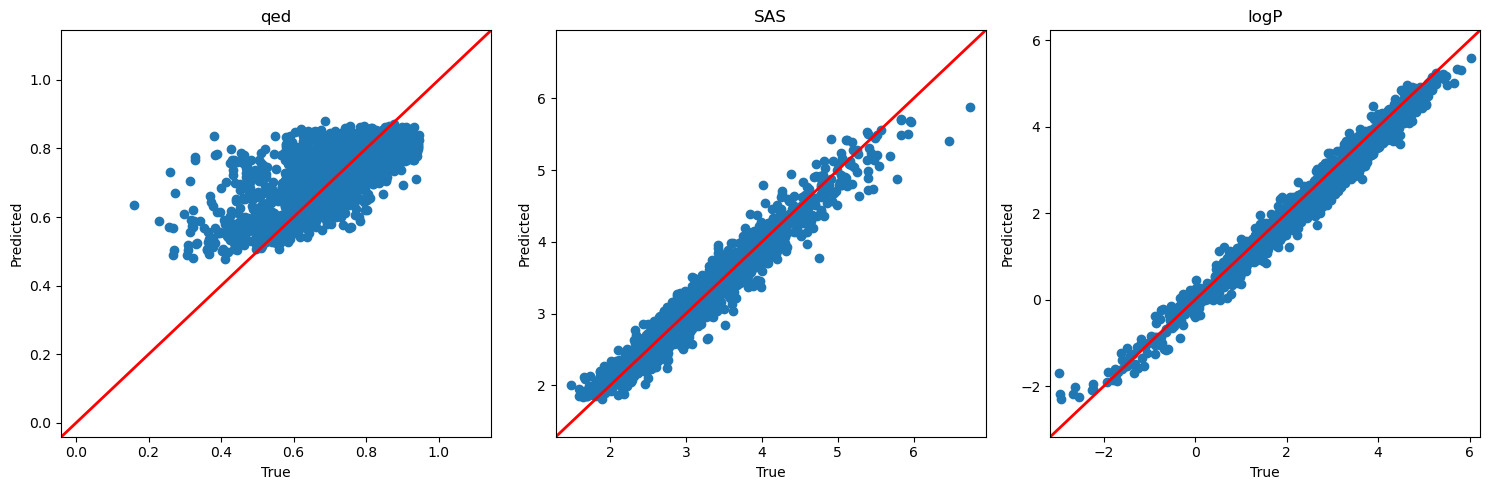

In [36]:
preds_train = []

encoder_torch.eval()
predictor_torch.eval()

for i in range(len(df_train_subset)):
    smiles = df_train_subset.iloc[i]["smiles"]
    input_onehot = smiles_to_hot(smiles, params, canonize_smiles=True)
    # input_onehot = input_onehot.transpose(0, 2, 1)
    input_onehot = torch.from_numpy(input_onehot).float()

    # encoding - prediction
    z_mean, encoder_output = encoder_torch(input_onehot)
    properties = predictor_torch(z_mean)

    preds_train.append(properties.detach().numpy())

preds_train = [pred[:, np.newaxis] for pred in preds_train]
preds_train = np.concatenate(preds_train, axis=1)[0]
trues_train = df_train_subset[["qed", "SAS", "logP"]].values


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].scatter(trues_train[:, i], preds_train[:, i])
    ax[i].set_xlabel("True")
    ax[i].set_ylabel("Predicted")
    ax[i].set_title(params["reg_prop_tasks"][i])
    # ensure y and x-axis limits are equal
    ax[i].set_xlim(np.min(trues_train[:, i]) - 0.2, np.max(trues_train[:, i]) + 0.2)
    ax[i].set_ylim(ax[i].get_xlim())
    # add y=x line in red
    ax[i].plot(np.linspace(ax[i].get_ylim()[0], ax[i].get_ylim()[1], 100), 
               np.linspace(ax[i].get_ylim()[0], ax[i].get_ylim()[1], 100), "r-", linewidth=2)
    # adjust subplots
fig.tight_layout()

mae_qed = np.mean(np.abs(trues_train[:, 0] - preds_train[:, 0]))
print("Mean Absolute Error (QED):", mae_qed)

In [37]:
ax[0].get_ylim()

(-0.040292646371000024, 1.144291701836)

Test set

Mean Absolute Error (QED): 0.07423454660358211


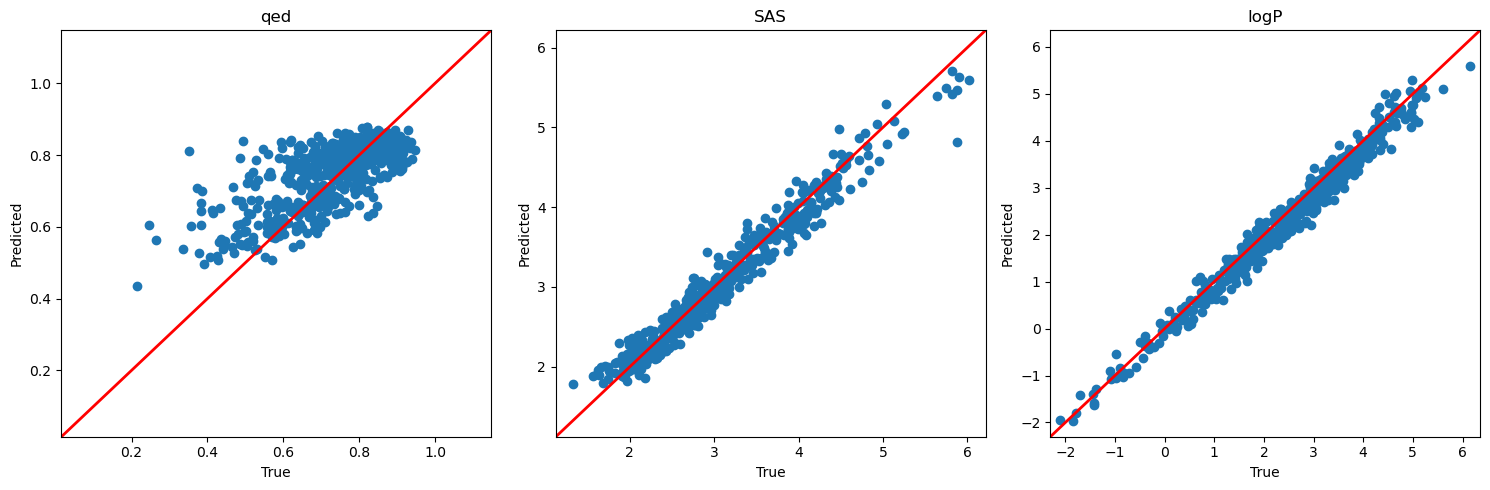

In [39]:
preds = []

encoder_torch.eval()
predictor_torch.eval()

for i in range(len(df_test)):
    smiles = df_test.iloc[i]["smiles"]
    input_onehot = smiles_to_hot(smiles, params, canonize_smiles=True)
    # input_onehot = input_onehot.transpose(0, 2, 1)
    input_onehot = torch.from_numpy(input_onehot).float()

    # encoding - prediction
    z_mean, encoder_output = encoder_torch(input_onehot)
    properties = predictor_torch(z_mean)

    preds.append(properties.detach().numpy())

preds = [pred[:, np.newaxis] for pred in preds]
preds = np.concatenate(preds, axis=1)[0]
trues = df_test[["qed", "SAS", "logP"]].values


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].scatter(trues[:, i], preds[:, i])
    ax[i].set_xlabel("True")
    ax[i].set_ylabel("Predicted")
    ax[i].set_title(params["reg_prop_tasks"][i])
    # ensure y and x-axis limits are equal
    ax[i].set_xlim(np.min(trues[:, i]) - 0.2, np.max(trues[:, i]) + 0.2)
    ax[i].set_ylim(ax[i].get_xlim())
    # add y=x line in red
    ax[i].plot(np.linspace(ax[i].get_ylim()[0], ax[i].get_ylim()[1], 100), 
               np.linspace(ax[i].get_ylim()[0], ax[i].get_ylim()[1], 100), "r-", linewidth=2)
    # adjust subplots
fig.tight_layout()

mae_qed = np.mean(np.abs(trues[:, 0] - preds[:, 0]))
print("Mean Absolute Error (QED):", mae_qed)

Predictions with Keras model

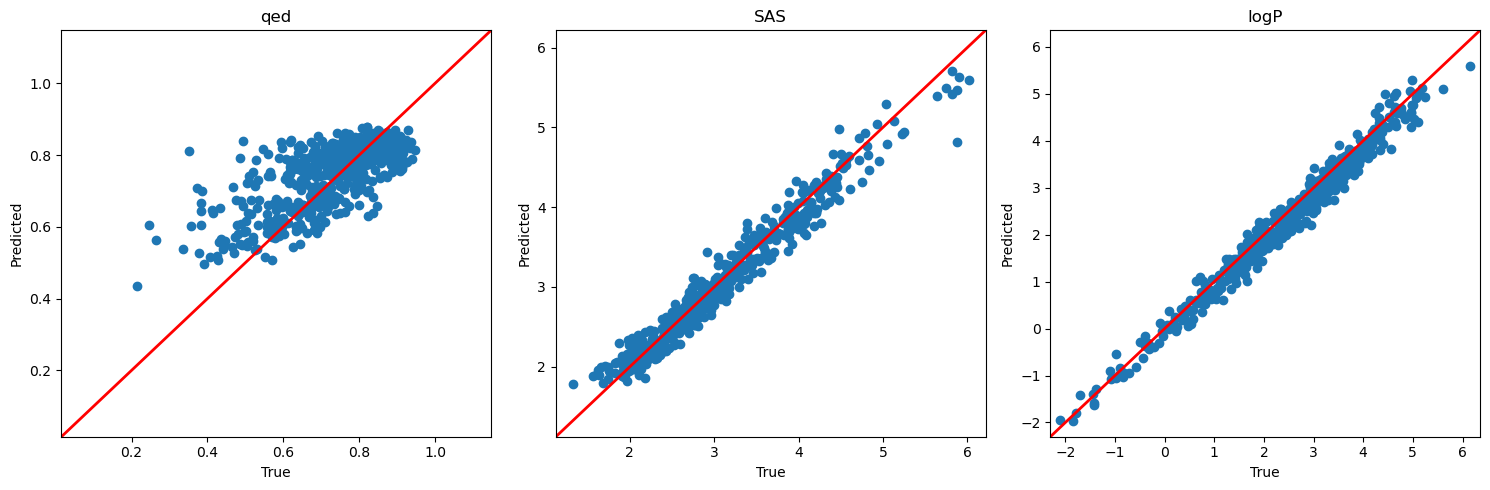

In [40]:
preds = []

for i in range(len(df_test)):
    smiles_1 = df_test.iloc[i]["smiles"]
    X_1 = smiles_to_hot(smiles_1, params, canonize_smiles=True)

    # encoding - prediction
    z_mean, enc_output = encoder(X_1)
    pred = prop_pred(z_mean).numpy()

    preds.append(pred)

preds = np.concatenate(preds, axis=0)#[0]
trues = df_test[["qed", "SAS", "logP"]].values

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].scatter(trues[:, i], preds[:, i])
    ax[i].set_xlabel("True")
    ax[i].set_ylabel("Predicted")
    ax[i].set_title(params["reg_prop_tasks"][i])
    # ensure y and x-axis limits are equal
    ax[i].set_xlim(np.min(trues[:, i]) - 0.2, np.max(trues[:, i]) + 0.2)
    ax[i].set_ylim(ax[i].get_xlim())
    # add y=x line in red
    ax[i].plot(np.linspace(ax[i].get_ylim()[0], ax[i].get_ylim()[1], 100), 
               np.linspace(ax[i].get_ylim()[0], ax[i].get_ylim()[1], 100), "r-", linewidth=2)
    # adjust subplots
fig.tight_layout()

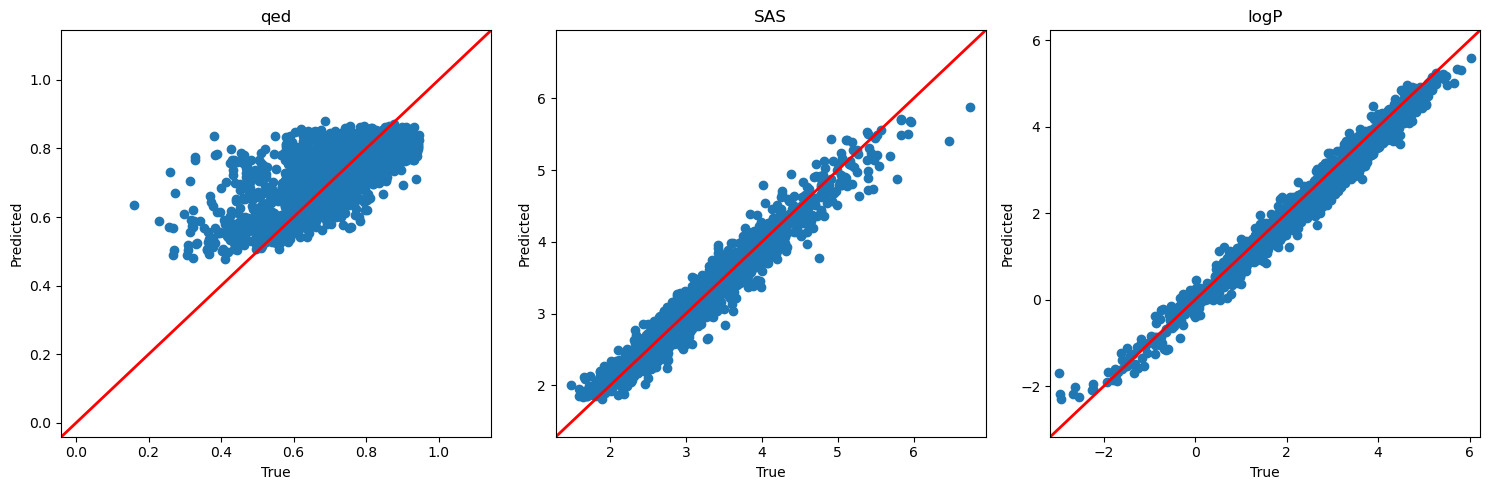

In [41]:
preds = []

for i in range(len(df_train_subset)):
    smiles_1 = df_train_subset.iloc[i]["smiles"]
    X_1 = smiles_to_hot(smiles_1, params, canonize_smiles=True)
    z_mean, enc_output = encoder(X_1)

    pred = prop_pred(z_mean).numpy()
    preds.append(pred)

preds = np.concatenate(preds, axis=0)
trues = df_train_subset[["qed", "SAS", "logP"]].values

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].scatter(trues[:, i], preds[:, i])
    ax[i].set_xlabel("True")
    ax[i].set_ylabel("Predicted")
    ax[i].set_title(params["reg_prop_tasks"][i])
    # ensure y and x-axis limits are equal
    ax[i].set_xlim(np.min(trues[:, i]) - 0.2, np.max(trues[:, i]) + 0.2)
    ax[i].set_ylim(ax[i].get_xlim())
    # add y=x line in red
    ax[i].plot(np.linspace(ax[i].get_ylim()[0], ax[i].get_ylim()[1], 100), 
               np.linspace(ax[i].get_ylim()[0], ax[i].get_ylim()[1], 100), "r-", linewidth=2)
    # adjust subplots
fig.tight_layout()

In [42]:
# Decode Keras encodings with Pytorch decoder - Test set
z_means = []
smiles_list = df_test["smiles"].values

for i in range(len(df_test)):
    smiles = smiles_list[i]
    input_onehot = smiles_to_hot(smiles, params, canonize_smiles=True)
    z_mean, enc_output = encoder(input_onehot)
    z_means.append(z_mean.numpy())

z_means = np.concatenate(z_means, axis=0)
z_means = torch.from_numpy(z_means).float()

# Decoding with Pytorch decoder
output_onehot = decoder_torch(z_means)
# output_onehot_2 = decoder_torch_2(z_means)
# output_onehot_3 = decoder_torch_3(z_means)
output_onehot_4 = decoder_torch_4(z_means)

output_onehot = output_onehot.detach().numpy()
# output_onehot_2 = output_onehot_2.detach().numpy()
# output_onehot_3 = output_onehot_3.detach().numpy()
output_onehot_4 = output_onehot_4.detach().numpy()

for i in range(10):
    print('{:20s} : {}'.format('Input', smiles_list[i]))
    print('{:20s} : {}'.format('Reconstruction 1', hot_to_smiles(output_onehot[i:i+1], indices_char)[0]))
    # print('{:20s} : {}'.format('Reconstruction 2', hot_to_smiles(output_onehot_2[i:i+1], indices_char)[0]))
    # print('{:20s} : {}'.format('Reconstruction 3', hot_to_smiles(output_onehot_3[i:i+1], indices_char)[0]))
    print('{:20s} : {}'.format('Reconstruction 4', hot_to_smiles(output_onehot_4[i:i+1], indices_char)[0]))
    print("\n\n")

Input                : COc1ccc(S(=O)(=O)Nc2ccccc2-n2nc(C)cc2C)cc1NC(C)=O

Reconstruction 1     : COOOOOCCCCCCCCCCCCCCCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnNNNNNNNNNNNNnnn
Reconstruction 4     : COc1ncc(c2CNC(C(CNCNCNCNCNCNCNCNcnnnnnncncncccnnccccccccccccccccccccccccccccccccncncncncncncncncccccncncncncnccccnnnnnnn



Input                : COc1ccc2c(c1)C(=O)N(c1ccc(C)cc1C)C(=O)/C2=C/Nc1ccccc1OC

Reconstruction 1     : COO11cccccccccCCCCCCCCCCCCOOOCCCCCCCCCCCCCCCCCCCCCCCcccccccccccccccccccccccccccccccccccccccccccccccccccCCCCCCCCCCCCCCCCC
Reconstruction 4     : COc1cccccccccc2C(C(COC(C(COC(C1C2C2C2C2C2C2C1C1C1C1c1c1c1ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc



Input                : COc1ccc(CC(=O)Nc2nnc(-c3ccccc3OC)o2)cc1C

Reconstruction 1     : COOOccccccCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCccCCCCCCCCCCCCCCCCCCCCCCNCCCCCccccNNNCCCCCCCCCCCCCCcc
Reconstruction 4     : COcncnnccc2c2C2C2C2C2COCOC1C(C(C

Conclusion: something is wrong with the decoder:
- activation layer: terminal GRU layer should have softmax at the new gate activation.

Creating mock models of the encoder to identify differences in outputs

In [43]:
# Mock Keras encoder
from keras.layers import Input, Convolution1D, BatchNormalization, Flatten
from keras.models import Model
from torch import nn
import torch.nn.functional as F

def mock_encoder_keras(params):
    # K_params is dictionary of keras variables
    x_in = Input(shape=(params["MAX_LEN"], params["NCHARS"]), name="input_molecule_smi")

    # Convolution layers
    x = Convolution1D(
        int(params["conv_dim_depth"] * params["conv_d_growth_factor"]),
        int(params["conv_dim_width"] * params["conv_w_growth_factor"]),
        activation="tanh",
        name="encoder_conv0",
    )(x_in)

    if params["batchnorm_conv"]:
        x = BatchNormalization(axis=-1, name="encoder_norm0")(x)

    for j in range(1, params["conv_depth"] - 1):
        x = Convolution1D(
            int(params["conv_dim_depth"] * params["conv_d_growth_factor"] ** (j)),
            int(params["conv_dim_width"] * params["conv_w_growth_factor"] ** (j)),
            activation="tanh",
            name="encoder_conv{}".format(j),
        )(x)
        if params["batchnorm_conv"]:
            x = BatchNormalization(axis=-1, name="encoder_norm{}".format(j))(x)
    
    x = Flatten()(x)

    return Model(x_in, x, name="encoder")


# Mock Torch decoder
class MockEncoderTorch(nn.Module):
    def __init__(self, params):
        super(MockEncoderTorch, self).__init__()
        self.params = params

        self.conv_layers = nn.ModuleList()
        self.conv_norm_layers = nn.ModuleList()

        # Convolution layers
        in_channels = params["NCHARS"]
        out_channels = int(params["conv_dim_depth"] * params["conv_d_growth_factor"])
        kernel_size = int(params["conv_dim_width"] * params["conv_w_growth_factor"])
        conv_layer = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_layers.append(conv_layer)
        if params["batchnorm_conv"]:
            # norm_layer = nn.BatchNorm1d(out_channels)
            norm_layer = CustomBatchNorm1d(out_channels)
            self.conv_norm_layers.append(norm_layer)

        in_channels = out_channels

        for j in range(1, params["conv_depth"] - 1):
        # for j in range(1, 2):
            out_channels = int(params["conv_dim_depth"] * params["conv_d_growth_factor"] ** j)
            kernel_size = int(params["conv_dim_width"] * params["conv_w_growth_factor"] ** j)
            conv_layer = nn.Conv1d(in_channels, out_channels, kernel_size)
            self.conv_layers.append(conv_layer)

            if params["batchnorm_conv"]:
                # norm_layer = nn.BatchNorm1d(out_channels)
                norm_layer = CustomBatchNorm1d(out_channels)
                self.conv_norm_layers.append(norm_layer)

            in_channels = out_channels

        self.flatten = nn.Flatten()

        # Middle layers
        # if params["middle_layer"] > 0:
        #     self.middle_layers = nn.ModuleList()
        #     self.dropout_layers = nn.ModuleList()
        #     self.middle_norm_layers = nn.ModuleList()

        #     # TODO: find a way to calculate in_features automatically
        #     in_features = out_channels * 94

            # for i in range(1, params["middle_layer"] + 1):
            #     out_features = int(params["hidden_dim"] * params["hg_growth_factor"] ** (params["middle_layer"] - i))
            #     middle_layer = nn.Linear(in_features, out_features)
            #     self.middle_layers.append(middle_layer)

            #     if params["dropout_rate_mid"] > 0:
            #         dropout_layer = nn.Dropout(params["dropout_rate_mid"])
            #         self.dropout_layers.append(dropout_layer)

            #     if params["batchnorm_mid"]:
            #         norm_layer = nn.BatchNorm1d(out_features)
            #         self.middle_norm_layers.append(norm_layer)

            #     in_features = out_features

        # # output has dim = hidden_dim = 100 (hyperparameters.py)
        # self.z_mean = nn.Linear(in_features, params["hidden_dim"])

    def forward(self, x):
        # Convolution layers
        for i in range(len(self.conv_layers)):
            x = self.conv_layers[i](x)
            x = F.tanh(x)  # activation
            # print(x.size())
            if self.params["batchnorm_conv"]:
                x = self.conv_norm_layers[i](x)
        # print(x.size())
        x = x.transpose(2, 1)
        x = self.flatten(x)
        # print("x.size(): ", x.size())

        # Middle layers
        # if self.params["middle_layer"] > 0:
        #     for i in range(len(self.middle_layers)):
        #         # print("TEST: ", i)
        #         x = self.middle_layers[i](x)
        #         x = F.tanh(x)
        #         if self.params["dropout_rate_mid"] > 0:
        #             x = self.dropout_layers[i](x)
        #         if self.params["batchnorm_mid"]:
        #             x = self.middle_norm_layers[i](x)

        # output has dim = hidden_dim = 100 (hyperparameters.py)
        # z_mean = self.z_mean(x)

        # return both mean and last encoding layer for std dev sampling
        # return z_mean, x
        return x

params_test = copy.deepcopy(params)
# params_test["middle_layer"] = 1
mock_torch = MockEncoderTorch(params_test)
mock_keras = mock_encoder_keras(params_test)

In [44]:
mock_keras.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_molecule_smi (InputL  [(None, 120, 35)]         0         
 ayer)                                                           
                                                                 
 encoder_conv0 (Conv1D)      (None, 112, 9)            2844      
                                                                 
 encoder_norm0 (BatchNormal  (None, 112, 9)            36        
 ization)                                                        
                                                                 
 encoder_conv1 (Conv1D)      (None, 104, 9)            738       
                                                                 
 encoder_norm1 (BatchNormal  (None, 104, 9)            36        
 ization)                                                        
                                                           

In [45]:
summary(mock_torch, input_size=(35, 120))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 9, 112]           2,844
 CustomBatchNorm1d-2               [-1, 9, 112]              18
            Conv1d-3               [-1, 9, 104]             738
 CustomBatchNorm1d-4               [-1, 9, 104]              18
            Conv1d-5               [-1, 10, 94]           1,000
 CustomBatchNorm1d-6               [-1, 10, 94]              20
           Flatten-7                  [-1, 940]               0
Total params: 4,638
Trainable params: 4,638
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.05
Params size (MB): 0.02
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [46]:
names = [weight.name for layer in encoder.layers for weight in layer.weights]
weights = encoder.get_weights()
for name, weight in zip(names, weights):
    print(name, weight.shape)

# Loading Keras weights into mock Keras encoder
# mock_torch.conv_layers[0].weight.data = torch.from_numpy(weights[0].transpose(2, 1, 0))  # T
# mock_torch.conv_layers[0].bias.data = torch.from_numpy(weights[1])
mock_keras.get_layer('encoder_conv0').set_weights((weights[0], weights[1]))
mock_keras.get_layer('encoder_norm0').set_weights((weights[2], weights[3], weights[4], weights[5]))
mock_keras.get_layer('encoder_conv1').set_weights((weights[6], weights[7]))
mock_keras.get_layer('encoder_norm1').set_weights((weights[8], weights[9], weights[10], weights[11]))
mock_keras.get_layer('encoder_conv2').set_weights((weights[12], weights[13]))
mock_keras.get_layer('encoder_norm2').set_weights((weights[14], weights[15], weights[16], weights[17]))

# Loading Keras weights into PyTorch mock encoder
mock_torch.conv_layers[0].weight.data = torch.from_numpy(weights[0].transpose(2, 1, 0))  # T
mock_torch.conv_layers[0].bias.data = torch.from_numpy(weights[1])
mock_torch.conv_norm_layers[0].weight.data = torch.from_numpy(weights[2])
mock_torch.conv_norm_layers[0].bias.data = torch.from_numpy(weights[3])
mock_torch.conv_norm_layers[0].running_mean.data = torch.from_numpy(weights[4])
mock_torch.conv_norm_layers[0].running_var.data = torch.from_numpy(weights[5])

mock_torch.conv_layers[1].weight.data = torch.from_numpy(weights[6].transpose(2, 1, 0))  # T
mock_torch.conv_layers[1].bias.data = torch.from_numpy(weights[7])
mock_torch.conv_norm_layers[1].weight.data = torch.from_numpy(weights[8])
mock_torch.conv_norm_layers[1].bias.data = torch.from_numpy(weights[9])
mock_torch.conv_norm_layers[1].running_mean.data = torch.from_numpy(weights[10])
mock_torch.conv_norm_layers[1].running_var.data = torch.from_numpy(weights[11])

mock_torch.conv_layers[2].weight.data = torch.from_numpy(weights[12].transpose(2, 1, 0))  # T
mock_torch.conv_layers[2].bias.data = torch.from_numpy(weights[13])
mock_torch.conv_norm_layers[2].weight.data = torch.from_numpy(weights[14])
mock_torch.conv_norm_layers[2].bias.data = torch.from_numpy(weights[15])
mock_torch.conv_norm_layers[2].running_mean.data = torch.from_numpy(weights[16])
mock_torch.conv_norm_layers[2].running_var.data = torch.from_numpy(weights[17])


encoder_conv0/kernel:0 (9, 35, 9)
encoder_conv0/bias:0 (9,)
encoder_norm0/gamma:0 (9,)
encoder_norm0/beta:0 (9,)
encoder_norm0/moving_mean:0 (9,)
encoder_norm0/moving_variance:0 (9,)
encoder_conv1/kernel:0 (9, 9, 9)
encoder_conv1/bias:0 (9,)
encoder_norm1/gamma:0 (9,)
encoder_norm1/beta:0 (9,)
encoder_norm1/moving_mean:0 (9,)
encoder_norm1/moving_variance:0 (9,)
encoder_conv2/kernel:0 (11, 9, 10)
encoder_conv2/bias:0 (10,)
encoder_norm2/gamma:0 (10,)
encoder_norm2/beta:0 (10,)
encoder_norm2/moving_mean:0 (10,)
encoder_norm2/moving_variance:0 (10,)
encoder_dense0/kernel:0 (940, 196)
encoder_dense0/bias:0 (196,)
encoder_dense0_norm/gamma:0 (196,)
encoder_dense0_norm/beta:0 (196,)
encoder_dense0_norm/moving_mean:0 (196,)
encoder_dense0_norm/moving_variance:0 (196,)
z_mean_sample/kernel:0 (196, 196)
z_mean_sample/bias:0 (196,)


In [47]:
# Verifying that the weights were correctly loaded
weights_mock = mock_keras.get_weights()
# Kernel
print("Keras: ", weights[0][:10, 0, 0])
print("Mock: ", weights_mock[0][:10, 0, 0])
# Bias
print("Keras: ", weights[1][:10])
print("Mock: ", weights_mock[1][:10])

Keras:  [-0.21570237 -0.15895224 -0.22720112 -0.15915883 -0.08744212  0.05481359
  0.01472872  0.16163267 -0.12182621]
Mock:  [-0.21570237 -0.15895224 -0.22720112 -0.15915883 -0.08744212  0.05481359
  0.01472872  0.16163267 -0.12182621]
Keras:  [-0.61631024 -0.28358114 -1.3836513   0.32617477 -0.28669962  0.80956167
  1.0463618   1.1587847   1.3315746 ]
Mock:  [-0.61631024 -0.28358114 -1.3836513   0.32617477 -0.28669962  0.80956167
  1.0463618   1.1587847   1.3315746 ]


In [48]:
# Output with mock Keras encoder
# create random input vector of size (1, 35, 120)
x = np.random.rand(1, 120, 35)
# encode with Keras
output_keras = mock_keras.predict(x)
# encode with PyTorch
x = torch.from_numpy(x.transpose(0, 2, 1)).float()
output_torch = mock_torch(x)
output_torch = output_torch.detach().numpy()
# output_torch = output_torch.transpose(0, 2, 1)

1/1 [==============================] - 0s 111ms/step


In [49]:
output_keras.shape

(1, 940)

In [50]:
output_torch.shape

(1, 940)

In [51]:
# output_keras[0, 0, :10]
output_keras[0, :10]

array([ 0.07968104,  0.09289552, -0.08612605, -0.02956867,  0.08682607,
        0.08987205, -0.00144007, -0.10086415, -0.08070433,  0.00616359],
      dtype=float32)

In [52]:
output_torch[0, :10]

array([ 0.07968101,  0.09289552, -0.08612603, -0.02956867,  0.08682609,
        0.08987207, -0.00144007, -0.10086414, -0.08070434,  0.00616359],
      dtype=float32)

In [53]:
# Identical outputs with conv1d

In [56]:
# Comparing outputs from full encoder

# create random input vector of size (1, 35, 120)
x = np.random.rand(1, 120, 35)
# encode with Keras
output_keras = encoder.predict(x)[0]
# encode with PyTorch
x = torch.from_numpy(x).float()
output_torch = encoder_torch(x)[0]
output_torch = output_torch.detach().numpy()
# output_torch = output_torch.transpose(0, 2, 1)

1/1 [==============================] - 0s 13ms/step


In [57]:
output_keras.shape

(1, 196)

In [58]:
output_torch.shape

(1, 196)

In [59]:
output_keras[0, :10]

array([ 0.02965858,  0.13177705,  0.14526805, -0.00088068, -0.01859034,
        0.16105506,  0.01936765,  0.05883314,  0.1181194 , -0.06906172],
      dtype=float32)

In [60]:
output_torch[0, :10]

array([ 0.0296586 ,  0.1317771 ,  0.1452679 , -0.0008807 , -0.01859034,
        0.16105491,  0.01936774,  0.0588331 ,  0.11811947, -0.06906179],
      dtype=float32)